In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [3]:
df1 = pd.read_csv(('gradient_boost_optimise_results.csv' ))
print(df1)

          y_true    y_pred  y_transformed          lon         lat
0      -0.416573 -0.893819      -0.893819   733918.149 -2611525.25
1      -0.286116 -0.867605      -0.867605   733576.615 -2611507.22
2      -0.326302 -0.664411      -0.664411   733235.911 -2611485.23
3      -0.430061 -0.826153      -0.826153   732898.186 -2611471.29
4      -0.620153 -1.114811      -1.114811   732564.331 -2611446.62
...          ...       ...            ...          ...         ...
259002 -1.506235 -1.822296      -1.822296   503053.300 -2177707.38
259003 -0.783225 -0.870340      -0.870340   543295.125 -2177704.15
259004 -1.517741 -1.325385      -1.325385   321851.553 -2177701.95
259005 -2.651306 -2.529641      -2.529641 -1080456.310 -2177688.38
259006 -2.352128 -1.783645      -1.783645 -1155306.740 -2177675.01

[259007 rows x 5 columns]


In [4]:
df2 = df1[["y_true", "y_pred"]]
var1 = df2.var
print(var1)

<bound method DataFrame.var of           y_true    y_pred
0      -0.416573 -0.893819
1      -0.286116 -0.867605
2      -0.326302 -0.664411
3      -0.430061 -0.826153
4      -0.620153 -1.114811
...          ...       ...
259002 -1.506235 -1.822296
259003 -0.783225 -0.870340
259004 -1.517741 -1.325385
259005 -2.651306 -2.529641
259006 -2.352128 -1.783645

[259007 rows x 2 columns]>


<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

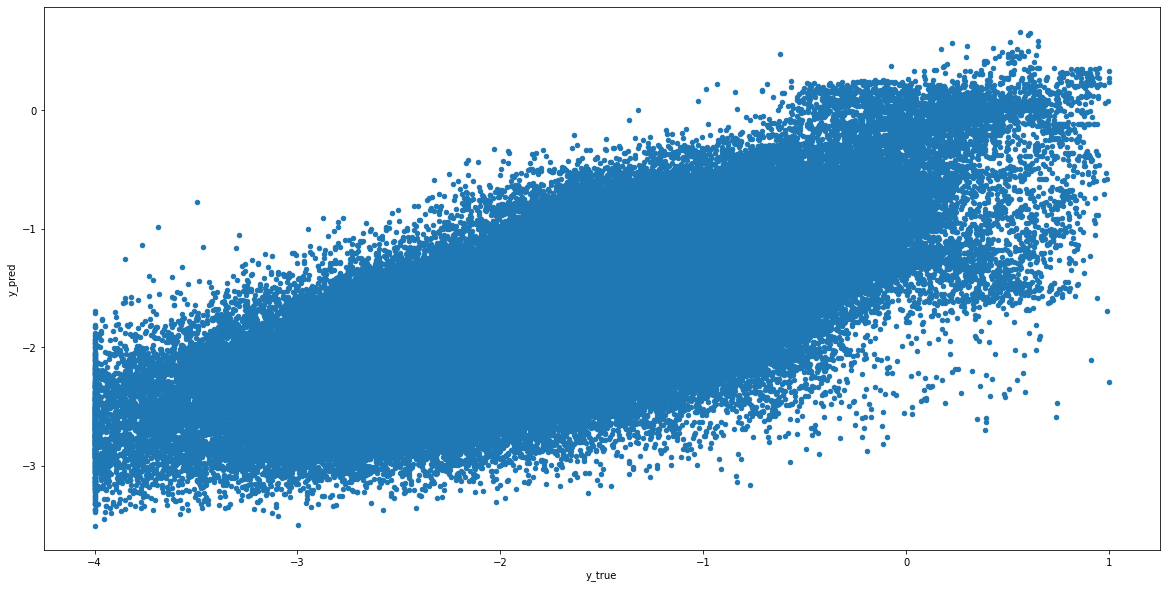

In [5]:
df1.plot.scatter(x="y_true", y="y_pred", figsize=(20,10))

In [6]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

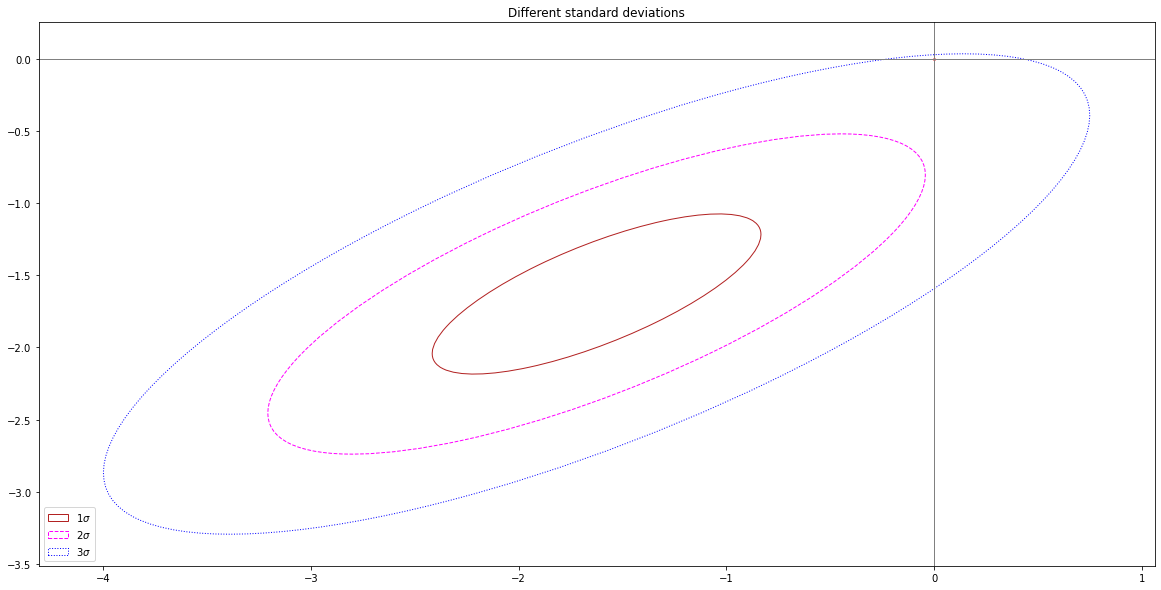

In [7]:
fig, ax_nstd = plt.subplots(figsize=(20, 10))

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = df1["y_true"], df1["y_pred"]


confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

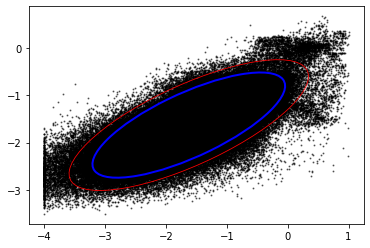

<Figure size 1600x1600 with 0 Axes>

In [8]:
def main(nstd=2.):
    """
    Generate an `nstd` sigma ellipse based on the mean and covariance of a
    point "cloud".
    """

    # Generate some random, correlated data
    points = df2
    # The 2x2 covariance matrix to base the ellipse on.
    cov = np.cov(points, rowvar=False)

    # Location of the center of the ellipse.
    mean_pos = points.mean(axis=0)

    # METHOD 1
    width1, height1, theta1 = cov_ellipse(points, cov, nstd)

    # METHOD 2
    width2, height2, theta2 = cov_ellipse2(points, cov, nstd)

    # Plot the raw points.
    df1["y_true"], df1["y_pred"]
    ax = plt.gca()
    plt.scatter(x, y, c='k', s=1, alpha=.5)
    figure(figsize=(20, 20), dpi=80)
    # First ellipse
    ellipse1 = Ellipse(xy=mean_pos, width=width1, height=height1, angle=theta1,
                       edgecolor='b', fc='None', lw=2, zorder=4)
    ax.add_patch(ellipse1)
    # Second ellipse
    ellipse2 = Ellipse(xy=mean_pos, width=width2, height=height2, angle=theta2,
                       edgecolor='r', fc='None', lw=.8, zorder=4)
    ax.add_patch(ellipse2)
    plt.show()


def eigsorted(cov):
    '''
    Eigenvalues and eigenvectors of the covariance matrix.
    '''
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


def cov_ellipse(points, cov, nstd):
    """
    Source: http://stackoverflow.com/a/12321306/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)

    return width, height, theta


def cov_ellipse2(points, cov, nstd):
    """
    Source: https://stackoverflow.com/a/39749274/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))

    # Confidence level
    q = 2 * norm.cdf(nstd) - 1
    r2 = chi2.ppf(q, 2)

    width, height = 2 * np.sqrt(vals * r2)

    return width, height, theta


if __name__ == '__main__':
    main()